In [1]:
%pip install ipywidgets

%matplotlib inline
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Device is cuda
torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])
torch.int64
cuda:0 <class 'torch.device'>


Training 1/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training 2/2:   0%|          | 0/2 [00:00<?, ?it/s]

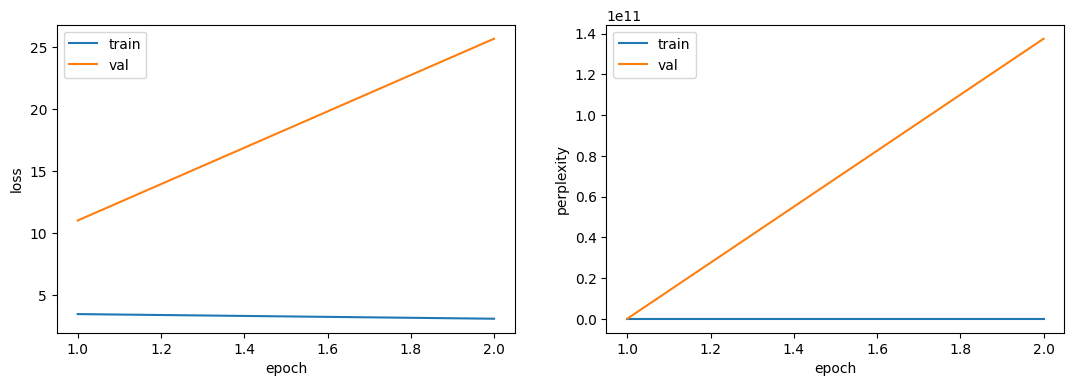

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import segmentation_models_pytorch as smp
from nuimages.nuimages import NuImages          


from train import train

# import gc

# gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

NUM_EPOCHS = 2
NUM_WORKERS = 2
BATCH_SIZE = 16
NUM_EXAMPLES=1 
FREEZE=False

class NuImagesDataset(Dataset):
    def __init__(self, dataroot, version, transform=None, target_transform=None, sensor_channels=None):
        self.nuim = NuImages(dataroot=dataroot, version=version, lazy=True, verbose=False)
        # Filter for camera keyframes
        self.sd_tokens = [
            sd['token']
            for sd in self.nuim.sample_data
            if sd['is_key_frame'] and
               self.nuim.shortcut('sample_data', 'sensor', sd['token'])['channel'] in (sensor_channels or
                   ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT'])
        ]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sd_tokens)

    def __getitem__(self, idx):
        sd_token = self.sd_tokens[idx]
        sample_data = self.nuim.get('sample_data', sd_token)
        img_path = os.path.join(self.nuim.dataroot, sample_data['filename'])
        image = Image.open(img_path).convert('RGB')

        sem_mask, _ = self.nuim.get_segmentation(sd_token) 

        if self.transform:
            image = self.transform(image)
        mask = Image.fromarray(sem_mask.astype(np.uint8))
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


resize_size = (256, 256)
original_size = (1024, 2048)

input_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Mask transforms (nearest-neighbor resize + to tensor)
target_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: t.squeeze(0).long()),
])

# root = os.getenv('NUIMAGES')
root = '/var/tmp/nuImages'
train_version = 'v1.0-mini'
val_version   = 'v1.0-mini'

# Datasets
train_dataset = NuImagesDataset(root, train_version,
                                transform=input_transform,
                                target_transform=target_transform)

val_dataset   = NuImagesDataset(root, val_version,
                                transform=input_transform,
                                target_transform=target_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

val_loader   = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS)


for images, masks in train_loader:
    print(images.shape)  # torch.Size([4, 3, H, W])
    print(masks.shape)   # torch.Size([4, H, W])
    print(masks.dtype)   # torch.int64
    break


nuim_train = NuImages(dataroot=root, version=train_version, lazy=True, verbose=False)
num_classes = len(nuim_train.category)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


from train import train

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=None,       # or define similarly for v1.0-test
      num_epochs=NUM_EPOCHS,
      num_examples=NUM_EXAMPLES,
      scheduler=None,
      freeze_encoder=False)

In [6]:
from nuimages.nuimages import NuImages

# Initialize the dataset
nuim = NuImages(dataroot='/var/tmp/full_nuImages/', version='v1.0-train', verbose=True)

# Retrieve the first sample
sample = nuim.sample[1]
key_camera_token = sample['key_camera_token']

# Render the image with annotations
nuim.render_image(
    sd_token=key_camera_token,
    annotation_type='all',
    with_category=True,
    out_path='rendered_image.png'
)


Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).
Loaded 67279 sample(s) in 0.100s,
Loaded 872181 sample_data(s) in 3.348s,
Loaded 73755 surface_ann(s) in 0.993s,
Loaded 25 category(s) in 0.000s,
Loaded 557715 object_ann(s) in 3.428s,
Loaded 12 attribute(s) in 0.005s,


In [ ]:
import os
import cv2
from nuimages.nuimages import NuImages

# Initialize nuImages
dataroot = '/var/tmp/full_nuImages'
version = 'v1.0-mini'
nuim = NuImages(dataroot=dataroot, version=version, verbose=True)

# Map category names to IDs (if you need them)
category_to_id = {cat['name']: idx for idx, cat in enumerate(nuim.category)}

# Get the first sample
sample = nuim.sample[0]
key_camera_token = sample['key_camera_token']
sample_data = nuim.get('sample_data', key_camera_token)
image_path = os.path.join(nuim.dataroot, sample_data['filename'])

# Load image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
h, w, _ = img.shape

# Retrieve annotations for this frame
annotations = [
    ann for ann in nuim.object_ann
    if ann['sample_data_token'] == key_camera_token
]

# Draw each bounding box
for ann in annotations:
    cx, cy, bw, bh = ann['bbox']  # center x, center y, width, height (pixels)
    # Convert to top-left & bottom-right
    x1 = int(cx / 2)
    y1 = int(cy / 2)
    x2 = int(cx / 2)
    y2 = int(cy / 2)

    # Get category name
    category = nuim.get('category', ann['category_token'])['name']

    # Draw rectangle and label
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img,
        category,
        (x1, max(0, y1 - 10)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
        cv2.LINE_AA
    )

# Save or display the result
output_path = os.path.join(dataroot, version, 'first_sample_bboxes.png')
cv2.imwrite(output_path, img)
print(f"Saved annotated image to {output_path}")
# To display interactively, uncomment:
# cv2.imshow('First Sample with BBoxes', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


Loading nuImages tables for version v1.0-mini...
Done loading in 0.000 seconds (lazy=True).
Loaded 25 category(s) in 0.001s,
Loaded 50 sample(s) in 0.000s,
Loaded 650 sample_data(s) in 0.003s,
Loaded 506 object_ann(s) in 0.003s,
Saved annotated image to /var/tmp/full_nuImages/v1.0-mini/first_sample_bboxes.png
